<h1 align="center">Introduction to Machine Learning - 25737-2</h1>
<h4 align="center">Dr. R. Amiri</h4>
<h4 align="center">Sharif University of Technology, Spring 2024</h4>


**<font color='red'>Plagiarism is strongly prohibited!</font>**


**Student Name**: Mohammad Armin Dehghan 

**Student ID**: 400101175





## Importing Libraries

First we import libraries that we need for this assignment.

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score
from sklearn.naive_bayes import GaussianNB
from sklearn.discriminant_analysis import LinearDiscriminantAnalysis



## Reading Data and Preprocessing

In this section, we want to read data from a CSV file and then preprocess it to make it ready for the rest of the problem.

First, we read the data in the cell below and extract an $m \times n$ matrix, $X$, and an $m \times 1$ vector, $Y$, from it, which represent our knowledge about the features of the data (`X1`, `X2`, `X3`) and the class (`Y`), respectively. Note that by $m$, we mean the number of data points and by $n$, we mean the number of features.

In [2]:
X, Y = None, None
df = pd.read_csv("data2_logistic.csv")
X = df[['X1', 'X2', 'X3']]
Y = df['Y']

print("Shape of X:", X.shape)
print("Shape of Y:", Y.shape)



Shape of X: (10000, 3)
Shape of Y: (10000,)


Next, we should normalize our data. For normalizing a vector $\mathbf{x}$, a very common method is to use this formula:

$$
\mathbf{x}_{norm} = \dfrac{\mathbf{x} - \overline{\mathbf{x}}}{\sigma_\mathbf{x}}
$$

Here, $\overline{x}$ and $\sigma_\mathbf{x}$ denote the mean and standard deviation of vector $\mathbf{x}$, respectively. Use this formula and store the new $X$ and $Y$ vectors in the cell below.

**Question**: Briefly explain why we need to normalize our data before starting the training.

**Answer**:


1. **Improving Convergence**: Normalizing data helps gradient-based optimization algorithms converge faster. When features are on different scales, the optimization process can be slower or may not converge at all. Normalization ensures that each feature contributes proportionally to the learning process.

2. **Avoiding Numerical Instability**: Large differences in the scale of features can lead to numerical instability, particularly in algorithms that involve computations like matrix inversions or multiplications. Normalization reduces the chances of such numerical instabilities.

3. **Enhancing Model Performance**: Normalization can improve the performance of certain algorithms, especially those based on distance metrics or regularization techniques. By ensuring that features are on similar scales, the model can better learn the underlying patterns in the data.

4. **Interpretability**: Normalized data can be easier to interpret, as the importance of each feature is not influenced by its scale. This can help in understanding the relative impact of different features on the model's predictions.

Overall, data normalization is a crucial preprocessing step that ensures the stability, convergence, and performance of machine learning models.


In [3]:
X_mean = np.mean(X, axis=0)
X_std = np.std(X, axis=0)

X_norm = (X - X_mean) / X_std

X_norm

,X1,X2,X3
0,-0.397146,-0.186215,1.399655
1,-1.386833,1.674903,0.078821
2,-1.586014,0.017019,1.684213
3,-0.289080,-0.434223,0.887443
4,0.454570,-1.248866,0.707742
...,...,...,...
9995,-1.127759,0.076140,0.035070
9996,-0.324092,-1.782389,1.503022
9997,1.212344,-0.697698,-0.230412
9998,-1.637735,-1.459527,-0.164010


Finally, we should add a column of $1$s at the beginning of $X$ to represent the bias term. Do this in the next cell. Note that after this process, $X$ should be an $m \times (n+1)$ matrix.

In [4]:
X_with_bias = np.hstack((np.ones((X_norm.shape[0], 1)), X_norm))

print("Shape of X_with_bias:", X_with_bias.shape)

Shape of X_with_bias: (10000, 4)


## Training Model

### Sigmoid Function
You should begin by implementing the $\sigma(\mathbf{x})$ function. Recall that the logistic regression hypothesis $\mathcal{h}()$ is defined as:
$$
\mathcal{h}_{\theta}(\mathbf{x}) = \mathcal{g}(\theta^\mathbf{T}\mathbf{x})
$$
where $\mathcal{g}()$ is the sigmoid function as:
$$
\mathcal{g}(\mathbf{z}) = \frac{1}{1+exp^{-\mathbf{z}}}
$$
The Sigmoid function has the property that $\mathbf{g}(+\infty)\approx 1$ and $\mathcal{g}(−\infty)\approx0$. Test your function by calling `sigmoid(z)` on different test samples. Be certain that your sigmoid function works with both vectors and matrices - for either a vector or a matrix, your function should perform the sigmoid function on every element.

In [5]:
def sigmoid(z):
    g = 1 / (1 + np.exp(-z))
    return g

In [6]:
# testing the functions 

z_scalar = 0
print("Sigmoid of scalar input:", sigmoid(z_scalar))

z_vector = np.array([-1, 0, 1])
print("Sigmoid of vector input:")
print(sigmoid(z_vector))

z_matrix = np.array([[-1, 0], [0, 1]])
print("Sigmoid of matrix input:")
print(sigmoid(z_matrix))


Sigmoid of scalar input: 0.5
Sigmoid of vector input:
[0.26894142 0.5        0.73105858]
Sigmoid of matrix input:
[[0.26894142 0.5       ]
 [0.5        0.73105858]]


### Cost Function 
Implement the functions to compute the cost function. Recall the cost function for logistic regression is a scalar value given by:
$$
\mathcal{J}(\theta) = \sum_{i=1}^{n}[-y^{(i)}\log{(\mathcal{h}_\theta(\mathbf{x}^{(i)}))}-(1-y^{(i)})\log{(1-\mathcal{h}_\theta(\mathbf{x}^{(i)}))}] + \frac{\lambda}{2}||\theta||_2^2
$$

In [7]:
def computeCost(theta, X, y, regLambda):
    '''
    Computes the objective function
    Arguments:
        theta is d-dimensional numpy vector
        X is a n-by-d numpy matrix
        y is an n-dimensional numpy vector
        regLambda is the scalar regularization constant
    Returns:
        a scalar value of the cost  ** make certain you're not returning a 1 x 1 matrix! **
    '''

    m = len(y)
    h = sigmoid(np.dot(X, theta))
    regularization_term = ( regLambda/ (2 * m)) * np.sum(theta[1:]**2)
    loss = np.sum(-y * np.log(h) - (1 - y) * np.log(1 - h)) / m + regularization_term
    return loss

### Gradient of the Cost Function
Now, we want to calculate the gradient of the cost function. The gradient of the cost function is a d-dimensional vector.\
We must be careful not to regularize the $\theta_0$ parameter (corresponding to the first feature we add to each instance), and so the 0's element is given by:
$$
\frac{\partial \mathcal{J}(\theta)}{\partial \theta_0} = \sum_{i=1}^n (\mathcal{h}_\theta(\mathbf{x}^{(i)})-y^{(i)})
$$

Question: What is the answer to this problem for the $j^{th}$ element (for $j=1...d$)?

**Answer:**
For the $j^{th}$ element (for $j=1...d$) of the gradient of the cost function, we need to calculate the partial derivative with respect to $\theta_j$. This can be done using the following formula:

$$
\frac{\partial \mathcal{J}(\theta)}{\partial \theta_j} = \sum_{i=1}^n (\mathcal{h}_\theta(\mathbf{x}^{(i)})-y^{(i)}) \cdot x_j^{(i)} + \lambda \theta_j
$$

Where:
- $\mathcal{J}(\theta)$ is the cost function.
- $\mathcal{h}_\theta(\mathbf{x}^{(i)})$ is the hypothesis function.
- $y^{(i)}$ is the actual output.
- $x_j^{(i)}$ is the $j^{th}$ feature of the $i^{th}$ instance.
- $\lambda$ is the regularization parameter.
- $\theta_j$ is the $j^{th}$ parameter.

This formula represents the regularized gradient descent update rule for $\theta_j$. The first term represents the contribution of the $j^{th}$ feature to the error, and the second term represents the regularization term, which penalizes large values of $\theta_j$ to prevent overfitting. 

However, as specified in the question, we don't regularize the $\theta_0$ parameter. So, for $j=0$, the regularization term is omitted:

$$
\frac{\partial \mathcal{J}(\theta)}{\partial \theta_0} = \sum_{i=1}^n (\mathcal{h}_\theta(\mathbf{x}^{(i)})-y^{(i)})
$$ 

This is because $\theta_0$ corresponds to the bias term and is not associated with any feature.


In [8]:
def computeGradient(theta, X, y, regLambda):
    '''
    Computes the gradient of the objective function
    Arguments:
        theta is d-dimensional numpy vector
        X is a n-by-d numpy matrix
        y is an n-dimensional numpy vector
        regLambda is the scalar regularization constant
    Returns:
        the gradient, an d-dimensional vector
    '''
    m = len(y)
    h = sigmoid(np.dot(X, theta))
    gradient = np.dot(X.T, (h - y)) / m
    gradient[1:] += (regLambda / m) * theta[1:]
    gradient[0] -= (regLambda / m) * theta[0]  # no regularization for theta_0
    return gradient

### Training and Prediction
Once you have the cost and gradient functions complete, implemen tthe fit and predict methods.\
Your fit method should train the model via gradient descent, relying on the cost and gradient functions. This function should return two parameters. The first parameter is $\theta$, and the second parameter is a `numpy` array that contains the loss in each iteration. This array is indicated by `loss_history` in the code.\
Instead of simply running gradient descent for a specific number of iterations, we will use a more sophisticated method: we will stop it after the solution hasconverged. Stop the gradient descent procedure when $\theta$ stops changing between consecutive iterations. You can detect this convergence when:
$$
||\theta_{new}-\theta_{old}||_2 <= \epsilon,
$$
for some small $\epsilon$ (e.g, $\epsilon=10E-4$).\
For readability, we’d recommend implementing this convergence test as a dedicated function `hasConverged`.

In [9]:
def fit(X, y, regLambda = 0.01, alpha = 0.01, epsilon = 1e-4, maxNumIters = 100):
    '''
    Trains the model
    Arguments:
        X           is a n-by-d numpy matrix
        y           is an n-dimensional numpy vector
        maxNumIters is the maximum number of gradient descent iterations
        regLambda   is the scalar regularization constant
        epsilon     is the convergence rate
        alpha       is the gradient descent learning rate
    '''
    
    m, n = X.shape
    theta = np.zeros(n)
    loss_history = []
    for _ in range(maxNumIters):
        
        gradient = computeGradient(theta, X, y, regLambda)
        theta_new = theta - alpha * gradient

        theta_old = theta
        theta = theta_new
        
        loss = computeCost(theta , X, y,regLambda)
        loss_history.append(loss)
        
        if hasConverged(theta_old, theta_new, epsilon):
            break
        
        
    
    return theta, np.array(loss_history)



def hasConverged(theta_old, theta_new, epsilon):
    '''
    Return if the theta converged or not
    Arguments:
        theta_old   is the theta calculated in prevoius iteration
        theta_new   is the theta calculated in current iteration
        epsilon     is the convergence rate
    '''
    return np.linalg.norm(theta_new - theta_old) <= epsilon

Finally, we want to evaluate our loss for this problem. Complete the cell below to calculate and print the loss of each iteration and the final theta of your model.

In [85]:
theta, loss_history = fit(X_with_bias, Y) 

print(theta)
print(loss_history)

[-0.07917597 -0.12794085  0.34107905  0.00717197]
[0.69138091 0.68962349 0.6878749  0.68613508 0.68440399 0.68268159
 0.68096783 0.67926266 0.67756604 0.67587794 0.67419829 0.67252707
 0.67086422 0.6692097  0.66756347 0.66592549 0.6642957  0.66267408
 0.66106056 0.65945512 0.65785771 0.65626828 0.65468679 0.6531132
 0.65154746 0.64998954 0.64843939 0.64689697 0.64536224 0.64383515
 0.64231566 0.64080374 0.63929933 0.63780241 0.63631291 0.63483082
 0.63335608 0.63188865 0.63042849 0.62897557 0.62752984 0.62609126
 0.62465978 0.62323539 0.62181802 0.62040764 0.61900422 0.6176077
 0.61621806 0.61483526 0.61345925 0.61209    0.61072746 0.6093716
 0.60802239 0.60667978 0.60534373 0.60401422 0.60269119 0.60137461
 0.60006445 0.59876067 0.59746323 0.5961721  0.59488723 0.5936086
 0.59233616 0.59106988 0.58980972 0.58855566 0.58730764 0.58606565
 0.58482963 0.58359957 0.58237541 0.58115714 0.5799447  0.57873808
 0.57753723 0.57634213 0.57515273 0.573969   0.57279092 0.57161844
 0.57045154 0.56

### Testing Your Implementation
To test your logistic regression implementation, first you should use `train_test_split` function to split dataset into three parts:

- 70% for the training set
- 20% for the validation set
- 10% for the test set

Do this in the cell below.

In [10]:
X_train, X_temp, y_train, y_temp = train_test_split(X_with_bias, Y, test_size=0.3, random_state=42)
X_val, X_test, y_val, y_test = train_test_split(X_temp, y_temp, test_size=0.33, random_state=42)

# Print the shapes of the resulting sets
print("Training set:", X_train.shape, y_train.shape)
print("Validation set:", X_val.shape, y_val.shape)
print("Test set:", X_test.shape, y_test.shape)

Training set: (7000, 4) (7000,)
Validation set: (2010, 4) (2010,)
Test set: (990, 4) (990,)


Then, you should complete `predict` function to find the weight vector and the loss on the test data.

In [88]:
def predict(X, theta):
    
    '''
    Use the model to predict values for each instance in X
    Arguments:
        theta is d-dimensional numpy vector
        X     is a n-by-d numpy matrix
    Returns:
        an n-dimensional numpy vector of the predictions, the output should be binary (use h_theta > .5)
    '''
    h_theta = sigmoid(np.dot(X, theta))
    predictions = (h_theta > 0.5).astype(int)
    
    return predictions

Now, run the `fit` and `predict` function for different values of the learning rate and regularization constant. Plot the `loss_history` of these different values for train and test data both in the same figure.

**Question**: Discuss the effect of the learning rate and regularization constant and find the best values of these parameters.

**Answer**:

### Learning Rate:
The learning rate controls the size of the steps taken during optimization. It influences the convergence speed and the stability of the learning process.

- **Effect on Convergence**: If the learning rate is too large, the optimization algorithm might overshoot the minimum and fail to converge. Conversely, if it's too small, the algorithm might take too long to converge or get stuck in a local minimum.
  
- **Stability and Robustness**: A well-tuned learning rate helps stabilize the optimization process, ensuring that the model converges efficiently without oscillating or diverging.

- **Impact on Training Time**: A higher learning rate can lead to faster convergence, reducing training time. However, it requires careful tuning to avoid overshooting. Conversely, a lower learning rate might lead to slower convergence but can produce more stable results.

### Regularization Constant (Lambda):
Regularization is a technique used to prevent overfitting by adding a penalty term to the loss function. The regularization constant controls the strength of this penalty.

- **Effect on Model Complexity**: A higher regularization constant penalizes complex models more strongly, encouraging simpler models. This can help prevent overfitting by discouraging the model from fitting noise in the training data.
  
- **Bias-Variance Tradeoff**: Increasing the regularization constant typically increases bias while reducing variance. This means the model might become less flexible but more generalizable.

- **Tuning for Generalization**: The regularization constant needs to be carefully tuned to strike a balance between bias and variance, optimizing the model's ability to generalize to unseen data.

- **Impact on Model Performance**: Too low regularization may lead to overfitting, while too high regularization may lead to underfitting. Finding the right value involves experimentation and validation on a separate validation dataset.

### Interaction:
The learning rate and regularization constant can interact in complex ways. For example, a higher learning rate might require stronger regularization to prevent overfitting, while a lower learning rate might tolerate less regularization. Careful experimentation and cross-validation are necessary to find the optimal combination for a specific dataset and model architecture.

In summary, both the learning rate and regularization constant play crucial roles in training machine learning models. Finding the right balance between them is essential for achieving good performance, generalization, and convergence.


Learning Rate: 0.01, Regularization Constant: 0.01
Train Loss: 0.5546027758455185, Test Loss: 0.5526605838713072
Learning Rate: 0.01, Regularization Constant: 0.1
Train Loss: 0.5546043045341296, Test Loss: 0.552667255254726
Learning Rate: 0.01, Regularization Constant: 1
Train Loss: 0.5546195900049212, Test Loss: 0.5527339607327266
Learning Rate: 0.05, Regularization Constant: 0.01
Train Loss: 0.3366088131976438, Test Loss: 0.33279799975409735
Learning Rate: 0.05, Regularization Constant: 0.1
Train Loss: 0.3366244132970638, Test Loss: 0.33287526647742616
Learning Rate: 0.05, Regularization Constant: 1
Train Loss: 0.3367803468093764, Test Loss: 0.3336474816130688
Learning Rate: 0.1, Regularization Constant: 0.01
Train Loss: 0.25272727021240754, Test Loss: 0.2489795972659286
Learning Rate: 0.1, Regularization Constant: 0.1
Train Loss: 0.25275999190516324, Test Loss: 0.24915037282627076
Learning Rate: 0.1, Regularization Constant: 1
Train Loss: 0.2530869276901948, Test Loss: 0.25085616481

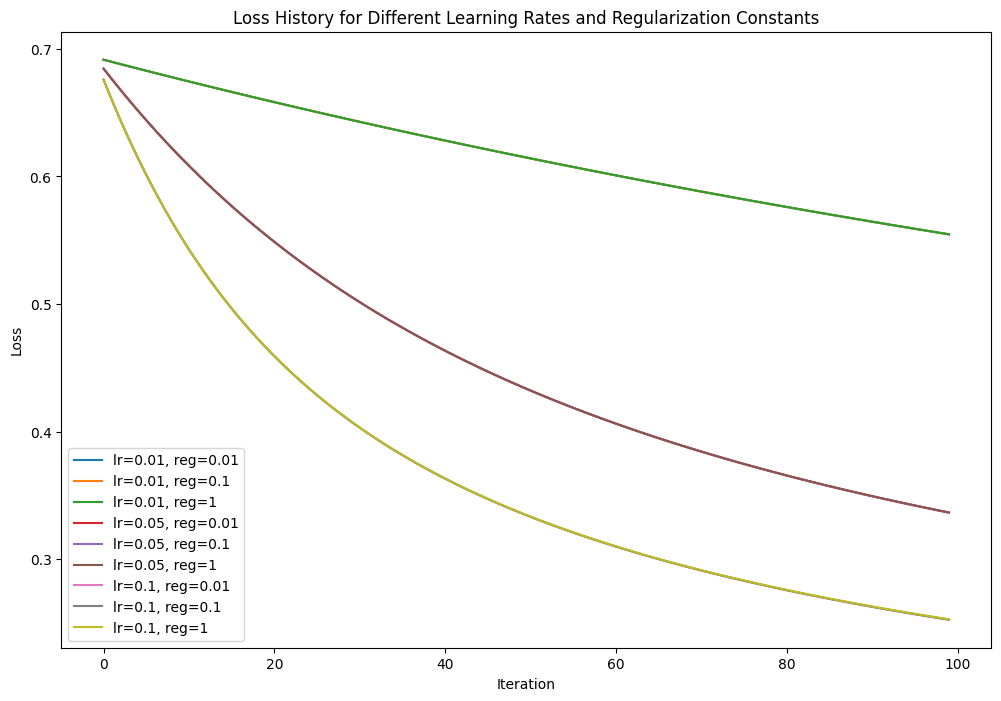

In [95]:
learning_rates = [0.01, 0.05, 0.1]
reg_constants = [0.01, 0.1, 1]

# Initialize a subplot for the loss history plot
plt.figure(figsize=(12, 8))

for lr in learning_rates:
    for reg in reg_constants:
        
        theta, train_loss_history = fit(X_train, y_train, regLambda=reg, alpha=lr)
        
        train_predictions = predict(X_train, theta)
        test_predictions = predict(X_test, theta)
        
        train_loss = computeCost(theta,X_train, y_train, reg)
        test_loss = computeCost(theta ,X_test, y_test, reg)
        
        plt.plot(train_loss_history, label=f"lr={lr}, reg={reg}")
        
        print(f"Learning Rate: {lr}, Regularization Constant: {reg}")
        print(f"Train Loss: {train_loss}, Test Loss: {test_loss}")

plt.xlabel('Iteration')
plt.ylabel('Loss')
plt.title('Loss History for Different Learning Rates and Regularization Constants')
plt.legend()
plt.show()

In [92]:
import warnings
warnings.filterwarnings("ignore")


## Naive Bayes

In this part, you will use the `GaussianNB` classifier to classify the data. You should not change the default parameters of this classifier. First, train the classifier on the training set and then find the accuracy of it on the test set.

**Question**: What is the accuracy of this method on test set?

**Answer**: The Accuracy is **92.32%**

In [11]:
Naive_Bayes_classifier = GaussianNB()

Naive_Bayes_classifier.fit(X_train, y_train)

y_pred = Naive_Bayes_classifier.predict(X_test)

accuracy = accuracy_score(y_test, y_pred)
print("Accuracy of Gaussian Naive Bayes classifier on test set:", accuracy)

Accuracy of Gaussian Naive Bayes classifier on test set: 0.9232323232323232


## LDA (Linear Discriminant Analysis)

In this part, you will use the `LinearDiscriminantAnalysis` classifier to classify the data. You should not change the default parameters of this classifier. First, train the classifier on the training set and then find the accuracy of it on the test set.

**Question**: What is the accuracy of this method on test set?

**Answer**: The Accuracy is **96.56%**

In [12]:
LDA_classifier = LinearDiscriminantAnalysis()

LDA_classifier.fit(X_train, y_train)

y_pred = LDA_classifier.predict(X_test)

accuracy = accuracy_score(y_test, y_pred)
print("Accuracy of Linear Discriminant Analysis classifier on test set:", accuracy)

Accuracy of Linear Discriminant Analysis classifier on test set: 0.9656565656565657


## Conclution

**Question**: What is the best method for classifying this dataset? What is the best accuracy on the test set?

**Answer**: Acording to the above accuracies between LDA and Naive Bayes , LDA performs better . 